# Chapter 8: Making Transformers Efficient in Production 


In this chapter, we explore the methods for more efficient transformers in regard with several constraints: memory, latency. 
Three approaches have been investigated: knowledge distillation, quantization and ONNX framework with BERT model on intent detection.

* **Intent Detection:** is the task of identifying the intent of a given query. It is very usefull especially for chatbots and assistans. 

For the task, we test BERT model with CLINC150 dataset. It contains 22.5K in-scope queries across 150 intents and 10 domains. 

In [ ]:
!pip install transformers 
!pip install datasets

In [ ]:
!pip install optuna

In [ ]:
!pip install onnxruntime

In [2]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

In [3]:
# Passing a query to get the intent 
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)


[{'label': 'car_rental', 'score': 0.549003541469574}]

## Creating a benchmark 

The benchmark evaluates the model with different constraints: model performance, latency and memory usage. 

In [4]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        # We'll define this later
        pass

    def compute_size(self):
        # We'll define this later
        pass

    def time_pipeline(self):
        # We'll define this later
        pass
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics


In [5]:
# Downloading dataset
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

Dataset clinc_oos downloaded and prepared to /root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [7]:
# Intents mappings 
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [8]:
# Loading the metric 
from datasets import load_metric

accuracy_score = load_metric("accuracy")

<ipython-input-8-f0829b231519>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")


In [9]:
# Accuracy metric expects the predictions to be integer 
# After using pipeline, we map the prediction to integers using intents mapping 
def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

# Define the class function
PerformanceBenchmark.compute_accuracy = compute_accuracy

In [10]:
# Let's first look the model 
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

In [11]:
# Saving the model in local
import torch
torch.save(pipe.model.state_dict(), "model.pt")

In [12]:
# Getting the model memory usage 
import torch
from pathlib import Path

def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [13]:
# Calculating the latency of the model 
import numpy as np
from time import perf_counter

def time_pipeline(self, query="What is the pin number for my account?"):
    """This overrides the PerformanceBenchmark.time_pipeline() method"""
    latencies = []
    # Warmup
    for _ in range(10):
        _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [14]:
# Now testing BERT model with benchmark class
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.15
Average latency (ms) - 153.88 +\- 48.19
Accuracy on test set - 0.867


## Knowledge Distillation 

Knowledge distillaiton is a method for training a smaller student network that mimics larger teacher network. 

In supervised tasks, the main idea is to augment the ground truth labels with a distribution of "soft probabilities" from the teacher model. 

The "soft probabilities" are obtained from the teacher networks output logits. After scaling these logits by a temperature hyperparameter, we apply a softmax to obtain the distribution. This distribution reveals the information of teacher's model decision boundary. 

We can then use Kullback-Leibler (KL) divergence to measure the difference between the softened probabilities of the student and the teacher.  This is also define knowledge distillation loss. In the inference the temperature is set to 1. 

KD can be used during pretraining to create a general purpose student that can be fine-tuned on downstream tasks. 

To create KND trainer we need: 
* new hyperparameters alpha and T 
* fine-tuned teacher model 
* new loss function to combine cross-entropy and KD loss


In [15]:
# Adding new parameters 
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [16]:
# Creating new loss function 
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        # obtain logits from student 
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        # reduction argument defines that the losses are averaged over the batch 
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        # First scale the logits with temperature 
        # Then normalize them before giving the loss_fct 
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss


**How to initialize student? ** 

KD works best when the teacher and the student are of the same model type. So for BERT asr teacher, we can choose DistilBERT as student. 

In [ ]:
# Tokenize the inputs for distilbert
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")


In [ ]:
# Logging the hub 
from huggingface_hub import notebook_login

notebook_login()

In [18]:
# Define the metrics 
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [20]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, 
    evaluation_strategy = "epoch",
    num_train_epochs=5, 
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    alpha=1,
    weight_decay=0.01,
    push_to_hub=False)

In [22]:
# Mapping the labels 
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id))

In [23]:
# Init function for student 
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [24]:
# Load the teacher 
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [25]:
# Train the model 
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, 
    args=student_training_args,
    train_dataset=clinc_enc['train'], 
    eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, 
    tokenizer=student_tokenizer)

distilbert_trainer.train()

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBert

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.288991,0.743226
2,3.786800,1.875629,0.837742
3,3.786800,1.157165,0.896129
4,1.692900,0.857340,0.913226
5,0.905800,0.772089,0.918387


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in d

TrainOutput(global_step=1590, training_loss=2.0514509908808103, metrics={'train_runtime': 331.7606, 'train_samples_per_second': 229.834, 'train_steps_per_second': 4.793, 'total_flos': 413896353421488.0, 'train_loss': 2.0514509908808103, 'epoch': 5.0})

In [ ]:
# Pushing to the hub 
distilbert_trainer.push_to_hub("Training completed!")


In [ ]:
finetuned_ckpt = "transformersbook/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

In [28]:
# Compute the performance of this model 
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 62.19 +\- 11.10
Accuracy on test set - 0.858


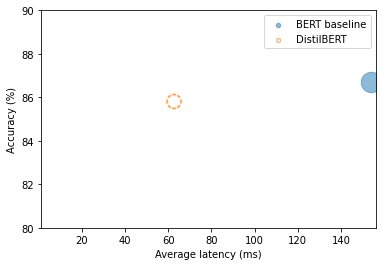

In [34]:
# A scatter plot to visualize the performances of the models 
import pandas as pd
import matplotlib.pyplot as plt 

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

In the plot, we can see that using faster model we can only loss 1\% in the accuracy.

### Finding the best parameters 

To find the best parameters for the model, we generally use grid search. In this section, we explore Optuna framework to optimize our objective to find the best parameters. 

We first define the hyperparameter space we wish to optimize over.

In [26]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [ ]:
# We need to specify the number of trials and the direction to optimize. 
# Since we want to best accuracy, the direction is "maximize"

best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space)

print(best_run)


In [38]:
# updating the training arguments and training again 
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

# Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

NameError: ignored

In [39]:
# Testing with benchmark again 
distilled_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/config.json
Model config DistilBertConfig {
  "_name_or_path": "transformersbook/distilbert-base-uncased-distilled-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
    "15": "what_are_your_hobbies",
    "16": "order",
    "17": "jump_start",
    "18": "schedule_meeting",
 

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at transformersbook/distilbert-base-uncased-distilled-clinc.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/tokenizer_config.json


Model size (MB) - 255.88
Average latency (ms) - 66.32 +\- 16.23
Accuracy on test set - 0.868


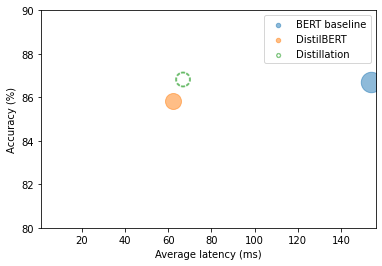

In [40]:
# plot the results 
plot_metrics(perf_metrics, optim_type)

## Quantization 

Instead of reducing the number of computations, the quantization approach represents the weights and the activations with low-precision data types like 8-bit integer (INT8) instead of the usual 32-bit floating point (FP32). 

The basic idea is to discretize the floating-point values in each tensor by mapping their range into a smaller one of fixed-point numbers and linearly distribution all values in between. 

The weights and activations in transformers tend to. take values in relatively small ranges, which make them prime candidates for the quantization.

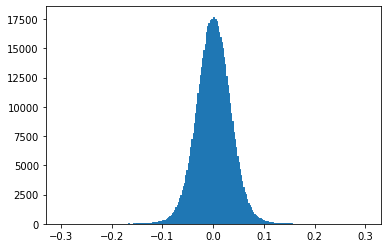

In [41]:
# Distribution of a layer of DistilBERT
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

The values of the weights are distributed in small range [-0.1,0.1] around zero. 

To obtain the quantized tensor, we need to invert the mapping, clamp the values, round them to the nearest integer and represent the result in INT8 type. 

In [42]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128)) 

In [43]:
# Quantization example 
(weights / scale + zero_point).clamp(-128, 127).round().char()


tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [44]:
# Using pytorch function 
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [46]:
%%timeit
weights @ weights

11 ms ± 374 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
# Time difference between quantized tensors 
from torch.nn.quantized import QFunctional

q_fn = QFunctional() 


In [48]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

400 µs ± 109 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


There are several ways to quantize the transformers: 

* **Dynamic quantization:** Nothing changes during training, only in inference. Weights and the activations of the model are quantized. It is simplest method. The bottleneck is the calculation between the integer and floating point due to the storage of the activations as floating-point format. 

* **Static quantization:** precomputes the quantization by observing the activation patterns on a representative sample ahead of inference time. It requires access to a good data sample and introduces an additional point to the pipeline. 

* **Quantization-aware training:** During training the FP32 values are rounded to mimic the effect of quantization. 

In [ ]:
# Dynamic quantization with pytorch 
from torch.quantization import quantize_dynamic

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)


In [50]:
# performance of quantized model 
pipe = pipeline("text-classification", model=model_quantized,
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.39
Average latency (ms) - 46.10 +\- 15.45
Accuracy on test set - 0.876


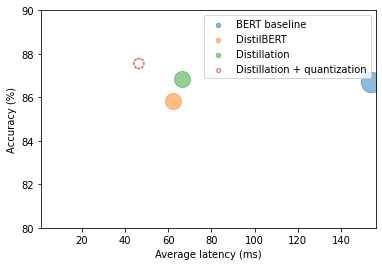

In [51]:
plot_metrics(perf_metrics, optim_type)


## ONNX runtime 

ONNX is an open standard that defines a common set of operators and a common file format to represent DNNs. A model can be exported to ONNX format to construct a computation graph. 

In [53]:
# First define OpenMP environment 
import os
from psutil import cpu_count

# OMP_NUM_THREADS sets the number of threads to use for parallel computation 
os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
# OMP_WAIT_POLICY specific that waiting threads should be active 
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [ ]:
# Converting the model to ONNX format 
from transformers.convert_graph_to_onnx import convert

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
        output=onnx_model_path, opset=12, pipeline_name="text-classification")


In [59]:
# Creating an inference 
from onnxruntime import (GraphOptimizationLevel, InferenceSession,
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [60]:
onnx_model = create_model_for_provider(onnx_model_path)

In [61]:
# Run with onnx format
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [62]:
# New pipeline to mimic text-classification for onnx
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [63]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.7848334}]

In [64]:
# Need new performance for ONNX
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [65]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.98
Average latency (ms) - 58.68 +\- 7.28
Accuracy on test set - 0.868


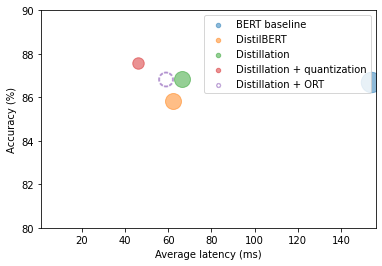

In [66]:
plot_metrics(perf_metrics, optim_type)


In [67]:
# Further quantization with ORT 
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.5/attention/MatMul]
Ignore MatM

In [68]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 64.33
Average latency (ms) - 15.13 +\- 2.66
Accuracy on test set - 0.876


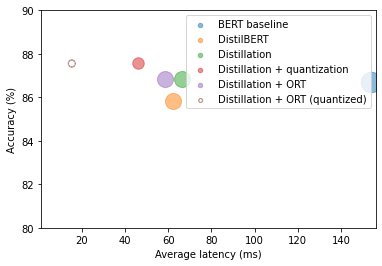

In [69]:
plot_metrics(perf_metrics, optim_type)


## Weight prunning 

The main idea in weight prunning is to gradually remove weight connections during training such that model becomes sparser. 

The most prunning methods calculate a matrix of importance of scores and then select the top k percent of weights by importance. Here k is another hyperparameter that control the amount of sparsity in the model. 

**Magnitude prunning:** calculates the scores according to the magnitude of the weights and then derives the masks. The approach is to first train the model to learn the important connections, then prun the least importance. The sparse model is then retrained and the process is repeated until the desired spasity is reached. 

(-)It is computationnaly expensive. 

(-) It is designed for pure supervised learning, where the importance is directly related to the task. 

**Movement prunning:** The idea is to gradually remove the weights during fine-tuning. The novelty is that both the weights and the scores are learned during fine-tuning. So instead of directly derived from the weights the scores are learned. 